In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, data

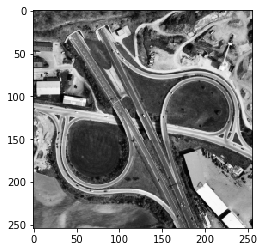

In [2]:
# Reading an image
image = io.imread("autopista.tif", as_gray=True)
plt.imshow(image, cmap="gray")

In [8]:
def resize_image(image, padding):
    """
    This function lets you resize an image for working with some operations that require
    adding (or extend) the borders of the input image, specially for Convolution and
    Binarization methods like Niblack's and Sauvola's.
    Returns the image resized.
    """
    image_height, image_width = image.shape
    new_image_height, new_image_width = 2 * padding + image_height, 2 * padding + image_width
    new_image = np.zeros((new_image_height, new_image_width))
    
    # Copy the original image at the center of the new extended image.
    new_image[padding:new_image_height - padding, padding:new_image_width - padding] = image
    
    # Get all borders
    image_left_border = np.array([image[:,0]]).T
    image_right_border = np.array([image[:,-1]]).T
    image_top_border = image[0,:]
    image_bottom_border = image[-1,:]
    
    # Get all corners
    # LT : Left-Top    | RT : Right-Top
    # LB : Left-Bottom | RB : Right-Bottom
    image_lt_corner = np.array([image[0,0]])
    image_rt_corner = np.array([image[0,-1]])
    image_lb_corner = np.array([image[-1,0]])
    image_rb_corner = np.array([image[-1,-1]])
    
    # Copy the left border
    new_image[padding:image_height + padding,
              0:padding] = np.tile(image_left_border, (1, padding))
    
    # Copy the right border
    new_image[padding:image_height + padding,
              image_width + padding:new_image_width] = np.tile(image_right_border, (1, padding))
    
    # Copy the top border
    new_image[0:padding,
              padding:image_width + padding] = np.tile(image_top_border, (padding, 1))

    # Copy the bottom border
    new_image[image_height + padding:new_image_height,
              padding:image_width + padding] = np.tile(image_bottom_border, (padding, 1))
    
    # Copy the corners
    new_image[0:padding, 0:padding] = np.tile(image_lt_corner, (padding, padding))
    new_image[0:padding, image_width + padding:new_image_width] = np.tile(image_rt_corner, (padding, padding))
    new_image[image_height + padding:new_image_height, 0:padding] = np.tile(image_lb_corner, (padding, padding))
    new_image[image_height + padding:new_image_height, image_width + padding:new_image_width] = np.tile(image_rb_corner, (padding, padding))
    
    return new_image

def convolve(image, kernel):
    image_width, image_height = image.shape
    kernel_width, kernel_height = kernel.shape
    padding = kernel_width // 2
    
    if kernel_width % 2 == 0: return None
    
    temporal_image = resize_image(image, padding)
    output_image = np.zeros((image_height, image_width))
    for i in np.arange(padding, image_width - padding):
        for j in np.arange(padding, image_height - padding):
            image_section = temporal_image[i - padding:i + padding, j - padding:j + padding]
            convolution = np.sum(np.multiply(image_section, kernel))
            output_image[i - padding, j - padding] = int(convolution)
    return output_image

In [9]:
gaussian_kernel = 1/273 * np.array([[1,4,7,4,1],
                           [4,16,26,16,4],
                           [7,26,41,26,7],
                           [4,16,26,16,4],
                           [1,4,7,4,1]])


a = convolve(image, gaussian_kernel)
print(a)
plt.imshow(a, cmap='gray')

ValueError: operands could not be broadcast together with shapes (4,4) (5,5) 

In [ ]:
a = np.array([[1,2,3],
              [3,4,5]])

b = np.array([[1,2,3],
              [3,4,5]])

In [ ]:
np.multiply(a,b)

In [ ]:
plt.imshow(image[0:100, 0:100])

In [ ]:
3//2